<h2><center>Tutorial on Latent Dirichlet Allocation</center></h2>

## Introduction
Latent Dirichlet Allocation(LDA) is a very powerful topic model to find topics in a given text. On the one hand, LDA help engineers and scientists find main topic components in a huge amount of documents. On the other hand, Since documents can be distinguished based on their different topics, many other natural languange processing such as text classification will have better result based on the result of LDA.

This tutorial will help you understand the basic machanism of sampling and inference from LDA topic model. Then we will introduce the implementation of this model and apply it to some data.

## A quick example
Instead of assigning one specific topic for one document, LDA consider it in the way that every documents is a combination of different topics. The number of topics is given, then basically the model will do two things: one is to find a distribution of these topics for each of the given documents; another is to find words distribution for each of the topics. Note that the name of each topics doesn't matter, what is important is their distribution. To achieve this, LDA also assign one topic for each word in each document (in article, we call this as "position") and then assign word for this position based on the topic assigned to this position. The following is an quick example of LDA model.
<img src="https://www.dropbox.com/s/azgtj4rbsvedpu1/Figure1.pdf?raw=1">

In the above figure, there are 5 very short documents(DOC1, DOC2, ...). Given 2 topics A and B. So what LDA do is:

1. find topic distribution for each of these 5 documents(only shows for first two documents here). 
2. find word distribution for each of these 2 topics(on the left of this figure). 
3. Assign one of 2 topics to each position in each document and assign word for each position. The color in the figure represent different topic assignment. For example, "ate" in document 1 is assigned topic A and "bananas" in document 2 is assigned topic B.

It is worthy noting that same word may be assigned to different topics, such as the "banana" in document 1 and "bananas" in document 2(after lemmatization they are same). The main task of LDA is to obtain the latent variables topic words distribution, document topics distribution and topic assignment for each position in each document.

## Model interpretation
Before going into this part, it is really recommended to watch this [video](http://videolectures.net/mlss09uk_blei_tm/). Actually, the speaker in this video is just the proposer of this model--Professor David M. Blei. His lecture is very helpful for you to understand this model.

### dirichlet distribution
[Dirichlet distribution](https://en.wikipedia.org/wiki/Dirichlet_distribution) describes a distribution over distribution. The mathmatical expression for it is:
$$f(x_1,x_2,\cdots,x_K;\alpha_1,\alpha_2,\cdots,\alpha_K)=\dfrac{1}{B(\alpha)}\prod_{i=1}^Kx_i^{\alpha_i-1}\sim Dir(\alpha_1,\alpha_2,\cdots,\alpha_K)$$
where $x_i, i\in 1,\cdots,K$ are random variables satisfying $\sum_{i=1}^Kx_i=1$ and $x_i\geqslant0$. Hence all $x_i$ can be seen as a distribution for some random variable and thus dirichlet distribution can be seen as a distribution over distribution. $\alpha_i$, $i\in1,\cdots,K$ are parameters for dirichlet. These parameters control the shape of the distribution. This may be abstract for the first time, you can see a good example of visualization of 3D Dirichlet dirtribution [here](http://blog.bogatron.net/blog/2014/02/02/visualizing-dirichlet-distributions/). 

Dirichlet distribution is chosen as prior for topic words distribution and document topics distribution. The reason is one good property of dirichlet distribution is that it is a [conjugate piror](https://en.wikipedia.org/wiki/Conjugate_prior) of multinomial distribution (to be introduced in the next part), which is chosed as statistical model for both topic words distribution and of document topics distribution. Hence, putting Dirichlet and multinomial distribution into LDA model will get relatively concise mathmatical result and help to inference from it. 

One thing to note is that when $\alpha_i$ is small, the distribution of $x_i, i\in 1,\cdots,K$ is very sparse, meaning that most of $x_i$ will actually toward zero while some $x_i$ approach relative large value. For LDA, one common choice is to set all $\alpha_i$ as same small value. Therefore, LDA model assumes that one document tends to consists of a few topics instead of a mixture of many topics. Same meaning there is no preference for any one of the topics.

### Multinomial distribution
[Multinomial distribution](https://en.wikipedia.org/wiki/Multinomial_distribution) is the generalization of binomial distribution. The mathmatical expression for it is:
$$f(x_1,x_2,\cdots,x_K;n,p_1,p_2,\cdots,p_K)=\dfrac{\Gamma(\sum_ix_i+1)}{\prod_i\Gamma(x_i+1)}\prod_{i=1}^Kp_i^{x_i}\sim Mult(p_1,p_2,\cdots,p_K)$$
where $n$ is number of trials and $x_i, i\in 1,\cdots,K$ is number $i$ appears with probability $p_i$ in each trial. 

Multinomial distribution is chosen as topic assignment distribution of each word and word assignment distirbution for one position in one document. Therefore, for each position in each document, we sample once from multinomial model(parameters provided by dirichlet model of document topics distribution) to get its topic and again sample once from another multinomial model(parameters provided by dirichlet model of topic words distribution).

### LDA model
Now let's talk about LDA model. There is a very good graphical model representing LDA model given by the first paper describing this model$^{[1]}$:
<img src="https://www.dropbox.com/s/kob0vdrrybq3cjw/Figure2.pdf?raw=1">
The statistical model can be expressed as follows:

Given document index $d=\{1,\cdots,D\}$, word index $w=\{1,\cdots,W\}$, $K$ topics and topic index $k=\{1,\cdots,K\}$, LDA assumes:
$$\beta_k\sim Dir(\beta_k|\eta_1,\eta_2,\cdots,\eta_W)$$

$$\theta_d\sim Dir(\theta_d|\alpha_1,\alpha_2,\cdots,\alpha_K)$$

$$z_{dw}\sim Mult(z_{dw}|\theta_d)$$

$$w_{dk}\sim Mult(w_{dk}|\theta,z_{dw}=k)$$

Please combine the figure and math expression to understand the following interpretation of this model: 

1. the topic words distribution is given by dirichlet distribution with hyper parameters $\eta$. It will generate K topics with different word distribution for each topic. Each topic includes a distribution of all words appear in all input documents.
2. the document topics distribution is given by dirichlet distribution with hyper parameters $\alpha$. It will generate D topic distributions with different topic distribution for each document. Each document includes a distribution of all K topics.
3. Assign each position in each document a topic $z_{dw}$ range from $1,\cdots,K$.
4. Assign each position in each document a word $w_{dk}$ from the words distribution corresponding to the given topic $z_{dw}=k$.

### Inference from model

One task of LDA is to inference latent variable(e.g. $\theta$, $\beta$ and $z$) given input texts. This is also where the name "latent" comes from. Although employing dirichlet and multinomial distribution make the model easier, it is still quite complicate to directly inference them from this model. However, there are some approximate inference methods for it and they are practical useful. Here are three main methods$^{[2]}$:
1. Gibbs sampling
2. Variational methods$^{[1]}$
3. Particle filtering$^{[3]}$

Here in our tutorial, we will give details about Gibbs sampling. For other two methods, you can find very good reference from respective links.

For [Gibbs sampling](https://en.wikipedia.org/wiki/Gibbs_sampling), We will introduce both standard Gibbs sampling and collapsed Gibbs sampling. Standard Gibbs sampling is easier while collapsed Gibbs sampling is more efficiently.

- Standard Gibbs sampling

There is a good explanation for applying standard Gibbs sampling to LDA, you can see it [here](https://wiseodd.github.io/techblog/2017/09/07/lda-gibbs/). Gibbs sampling is a method from [Markov Chain Monte Carlo](https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo). Generally, we do not do mathmatical derivation from the model. Instead we sample the latent variables alternatively and update one random variable whle fixing all others. Iterating the above steps many times until approaching some criterion and we get approximate latent variables.

Here we will ignore the process of derivation and directly give the sampling formula as follows:
$$p(\beta_k|z,w)=Dir(\eta+n_{1:W}(w_{(1:D),k}))$$

$$p(\theta_d|z_{d,1:W},\beta)=Dir(\alpha+n_{1:K}(z_{d,1:W}))$$

$$p(z_{dw}|z_{-dw},w,\theta_d,\beta)\propto p(z_{dw}|\theta_d)p(w|\beta_{k=z_{dw}},z_{dw})$$

Let's take a look at these three formulas:

1. the first formula is about sampling topic words distribution $\beta_k$ given the topic $k$, all words in this topic in all document($1:D$) $w_{(1:D),k}$. Since Dirichlet distribution is conjugate to multinomial distribution, the posterior distribution of $\beta_k$ is still dirichlet while parameters controling each word need to update. Updating is simply add term $n_{1:W}(w_{(1:D),k})$, which is a count vector to count number of each word($1:W$) in topic $k$ in all documents($1:D$) . We repeat this for all topics($1:K$).

2. the second formula is about sampling document topics distribution $\theta_d$ given the document $d$, all positions in this document $z_{d,1:W}$ and all topic words distribution $\beta$. Similarly, since Dirichlet distribution is conjugate to multinomial distribution, the posterior distribution of $\theta_d$ is still dirichlet while parameters controling each topic need to update. Updating is simply add term $n_{1:K}(z_{d,1:W})$, which is a count vector to count number of $z=k$ in all words($1:W$) in document $d$ for each topic $1:K$. We repeat this for all documents($1:D$).

3. the third formula is about sampling topic assignment for each position in each document $z_{dw}$ given all other position's topic assignment $z_{-dw}$, topics distribution for this document $\theta_d$ and all topic words distribution $\beta$. This is posterior probability of $z_{dw}$. Therefore, it is proportional to prior times likelihood. The prior term is $p(z_{dw}|\theta_d)$, meaning given document d's topic distribution $\theta_d$, the probability of seeing $z_{dw}$ for position $w$. The likelihood term is $p(w|\beta_{k=z_{dw}},z_{dw})$, meaning given topic $k=z_{dw}$ words distribution $\beta_{k=z_{dw}}$ and topic assignment of position $w$ in document d $z_{dw}$, the probability of seeing word $w$.

So far we have a basic method to inference latent variable from LDA model. However, this is not computational efficiently since we need to calculate for three kind of latent variables (acutally the total number is not too less than $D+K+DW$) in each iteration. Hence, we introduce collapsed Gibbs sampling in the following part.

- Collapsed Gibbs sampling

Compared to standard Gibbs sampling, collapsed Gibbs sampling is more efficient. The reason is that it integrates out the latent variable $\theta$ and $\beta$. What is left is only $z_{dw}$ for each position in each document. Wikipedia for LDA has a specific derivation of [collapsed Gibbs sampling](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation#Inference). Here we ignore the process of that and give the result formula directly as follows:
$$p(z_{dw}|z_{-dw},w)\propto (n_{z}(z_{-dw})+\alpha_{z_{dw}})\dfrac{n_{w}(w_{1:D,z_{-dw}})+\beta_{w}}{\sum_{w'} n_{w'}(w_{1:D,z_{-dw}})+\sum_{\beta_{1:W}}}$$

One easy way to understand this formula is that instead of calculating latent variable $\theta$ and $\beta$ from their distribution formula, we directly calculate them from the sample we get, e.g. empirical version. It can be seen from the following formulas:
$$\theta_d \approx \dfrac{n_{z}(z_{-dw})+\alpha_{z_{dw}}}{\sum_{z'}n_{z'}(z_{-dw})+\sum_{z'}{\alpha_{1:K}}}\quad
\beta_k \approx \dfrac{n_{w}(w_{1:D,z_{-dw}})+\beta_{w}}{\sum_{w'} n_{w'}(w_{1:D,z_{-dw}})+\sum_{\beta_{1:W}}}$$

Now let's implement them!

## Model implementation
For, Standard Gibbs sampling
There is a good material for explaining collapsed Gibbs sampling and its algorithm [here](http://u.cs.biu.ac.il/~89-680/darling-lda.pdf). 

For, Collapsed Gibbs sampling
Please look at this reference $[4]$ for pseudo code of collapsed Gibbs sampling.

The whole code can also be found in the following. You can read it carefully as they are heavily commented . 

Before coding, one thing need to be noted is that the format of input documents. These input documents need to be processed as bag of words vector to make sure they have same length. Although it is seemlingly tougher to count each latent variables, still, we can make our life easier via construct three index vectors. They are the index of words for every word in all documents idx_W, the index of each word's document idx_D, the index of each word's topic Z.

In [2]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter

In [3]:
class myLDA:
    def __init__(self, N_K=10, alpha=1, eta=1):
        """
        Model initialization
        
        Args:
            N_K: number of topics specified to put in the model
            alpha: prior parameter for dirichlet distribution of document proportion
            eta: prior parameter for dirichlet distribution of topic proportion
        """
        np.random.seed(1)
        self.N_K = N_K
        self.alpha = alpha
        self.eta = eta
        
    # implement inference of LDA via standard Gibbs Sampling
    def lda_sgs(self,D ,max_iter=100):
        """
        Model for latent dirichlet allocation. Inferenced via standard gibbs sampling.

        Args:
            D: a list of documents.
                N_D: number of documents
                N_W: number of words. Different between each document. 
            max_iter: maximum number of iteration used for gibbs sampling
        Returns:
            (Theta, Beta, Word): a tuple consist of document topic proportion ndarray Theta and topic word proportion ndarray and a list of all unique words
        """
        
        idx_W, idx_D = self.matrix_to_list(D)
        N_D,N_W = D.shape # get the number of documents and the number of unique words
        
        alpha_vec = self.alpha*np.ones(self.N_K)
        eta_vec = self.eta*np.ones(N_W)
        
        # Theta: Document topic proportion
        Theta = np.zeros([N_D,self.N_K])
        for d in range(N_D):
            Theta[d] = np.random.dirichlet(alpha_vec)
            
        # Beta: Topic word proportion
        Beta = np.zeros([self.N_K,N_W])
        for k in range(self.N_K):
            Beta[k] = np.random.dirichlet(eta_vec)

        # Z: Topic assignment
        Z = np.zeros(len(idx_W)) # the kth element represent the kth word's topic
        n_d_k = np.zeros([N_D,self.N_K]) # matrix of number of kth topic in dth document -> document topic proportion
        n_w_k = np.zeros([N_W,self.N_K]) # matrix of number of word w in kth topic -> topic word distribution
        for idx_w in range(len(idx_W)):
            d = idx_D[idx_w] # get the word w's document
            w = idx_W[idx_w] # get the idx_wth word
            z_new = np.random.multinomial(1, Theta[d]).argmax() # randomly generate the topic
            n_d_k[d][z_new] += 1
            n_w_k[w][z_new] += 1
            Z[idx_w] = z_new
        
        for it in  range(max_iter): # loop for each iteration
            
            # step1: update topic word propostion Beta
            for k in range(self.N_K): # loop for each topic
                eta_vec = self.eta*np.ones(N_W)
                Beta[k] = np.random.dirichlet(eta_vec + n_w_k[:,k])
                
            # Step2: update document topic proportion Theta
            for d in range(N_D): # loop for each document
                alpha_vec = self.alpha*np.ones(self.N_K)
                Theta[d] = np.random.dirichlet(alpha_vec + n_d_k[d]) # re-sample document topic proportion Theta
                
            # step3: update word topic assignment Z
            for idx_w in range(len(idx_W)): # loop for each word
                d = idx_D[idx_w] # get the word w's document
                w = idx_W[idx_w] # get the idx_wth word
                z = int(Z[idx_w]) # get the idx_wth word's current topic assignment
                n_d_k[d][z] -= 1
                n_w_k[w][z] -= 1
                prob_vec = np.exp(np.log(Theta[d]) + np.log(Beta[:,w])) # probablity of likelihood x prior (vector of topics)
                posterior_vec = prob_vec / np.sum(prob_vec) # get posterior after normalization
                z_new = np.random.multinomial(1,posterior_vec).argmax()
                Z[idx_w] = z_new
                n_d_k[d][z_new] += 1
                n_w_k[w][z_new] += 1
                
        return (Theta, Beta)     
            
    # implement inference of LDA via collapsed Gibbs Sampling
    def lda_cgs(self,D, max_iter=100): 
        """
        Model for latent dirichlet allocation. Inferenced via collapsed gibbs sampling.

        Args:
            D: a sparse matrix representation of documents via bag of words. shape = [N_D,N_W]
                N_D: number of documents
                N_W: number of words.
            max_iter: maximum number of iteration used for gibbs sampling
        Returns:
            (Theta, Beta): a tuple consist of document topic proportion ndarray Theta and topic word proportion ndarray.
        """
        
        idx_W, idx_D = self.matrix_to_list(D)
        N_D,N_W = D.shape # get the number of documents and the number of unique words
        
        n_d_k = np.zeros([N_D,self.N_K]) # matrix of number of kth topic in dth document -> document topic proportion
        n_w_k = np.zeros([N_W,self.N_K]) # matrix of number of word w in kth topic -> topic word distribution
        n_allw_k = np.zeros(self.N_K) # vector of number of all words in kth topic
        
        # initialize Z: Topic assignment
        Z = np.zeros(len(idx_W)) # the kth element represent the kth word's topic
        
        #loop for each word in all documents to construct three matrix: n_d_k, n_w_k, n_allw_k
        for idx_w in range(len(idx_W)):
            d = idx_D[idx_w] # get the word w's document
            w = idx_W[idx_w] # get the idx_wth word
            z_new = np.random.randint(self.N_K) # randomly generate the topic 
            n_d_k[d][z_new] += 1
            n_w_k[w][z_new] += 1
            n_allw_k[z_new] += 1
            Z[idx_w] = z_new
        
        for it in range(max_iter): # loop for each iteration
            for idx_w in range(len(idx_W)):
                d = idx_D[idx_w] # get the idx_wth word's document
                w = idx_W[idx_w] # get the idx_wth word
                z = int(Z[idx_w]) # get the idx_wth word's current topic assignment
                
                n_d_k[d][z] -= 1
                n_w_k[w][z] -= 1
                n_allw_k[z] -= 1
                
                p = np.zeros(self.N_K)
                for k in range(self.N_K): # loop for each topic
                    p[k] = (n_d_k[d][k] + self.alpha) * (n_w_k[w][k] + self.eta) / (n_allw_k[k] + self.eta * N_W)# get current word's each topic assignment probability (un-normalized)
                p = p/p.sum()
                
                z_new = np.random.choice(self.N_K,p=p)
                Z[idx_w] = z_new
    
                n_d_k[d][z_new] += 1
                n_w_k[w][z_new] += 1
                n_allw_k[z_new] += 1
        
        return (n_d_k/np.sum(n_d_k,axis=1)[:,np.newaxis], np.transpose(n_w_k/n_allw_k))
                
    # convert a sparse matrix of document(represented as bag of words) to lists of word index and of document index            
    def matrix_to_list(self, X):
        """
        Convert a matrix of document to a list of word index and a list of document index. 
        The input matrix should be a sparse matrix.
        The kth element in the list of document index corresponding to the kth word.
        Args:
            X: a sparse matrix of documents.
        Returns:
            (idx_W, idx_D): a tuple consist of a list of word index and a list of document index
        """
        X = X.tocoo()
        data = X.data
        row = X.row
        col = X.col
        idx_W = np.repeat(col,data)
        idx_D = np.repeat(row,data)
        
        return (idx_W, idx_D)
    
    def visualization(self, Theta ,Beta ,n='all', m='all'):
        """
        Visualize the document topic proportion and topic word distribution
        Args:
            Theta: document topic proportion.
            Beta: topic word distribution for Theta.
            n: number of topics to visualize. Default is all. Ordered by value
            m: number of words to visualize for Beta. Default is all. Ordered by value
        """
        if(n=='all' or n > Theta.shape[1]): n = Theta.shape[1]
        if(m=='all' or m > Beta.shape[1]): m = Beta.shape[1]
        
        plot_Theta_index = Theta.argsort(axis=1)[:,::-1][:,:n]
        plot_Beta_index = Beta.argsort(axis=1)[:,::-1][:,:m]
        # get the row/column index of item to be plot
        col_Theta = list(plot_Theta_index.flat)
        col_Beta = list(plot_Beta_index.flat)
        row_Theta = np.repeat(np.arange(Theta.shape[0]),n)
        row_Beta = np.repeat(np.arange(Beta.shape[0]),m)
        plot_Theta = Theta[row_Theta,col_Theta].reshape([Theta.shape[0],n])
        plot_Beta = Beta[row_Beta,col_Beta].reshape([Beta.shape[0],m])
        
        fig, ax= plt.subplots(ncols=Theta.shape[0])
        i=0
        for col in ax:
            col.bar(plot_Theta_index[i], plot_Theta[i])
            i += 1
        plt.tight_layout()
        
        fig, ax= plt.subplots(ncols=Beta.shape[0])
        i=0
        for col in ax:
            col.bar(plot_Beta_index[i], plot_Beta[i])
            i += 1
        plt.tight_layout()
        
        plt.show()

## Play with our model
Here we show two examples. One is a very toy example to check if our model works well. In another example, we will get some short paragraph from real news as our document and put them into our LDA model and the python sklearn package's LDA model and compare their result. The result may be a little different since we use Gibbs sampling to do inference while sklearn use variational method.

__note__: In the real application, LDA works not good if documents are too short. It works well for hung amount of documents and also after some pre-processing such as lemmatization, getting rid of stop words, etc.

- Toy example

******Standard Gibbs Sampling******
Document topic proportion:
[[ 0.05501766  0.94498234]
 [ 0.15035029  0.84964971]
 [ 0.80038678  0.19961322]
 [ 0.76326565  0.23673435]
 [ 0.04671193  0.95328807]]
Topic word proportion
[[ 0.27760591  0.43785051  0.0043018   0.06959751  0.21064427]
 [ 0.00142387  0.04409961  0.54931774  0.34720817  0.05795061]]
Visualization


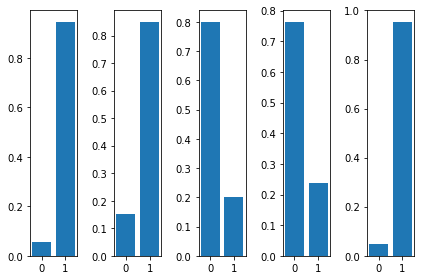

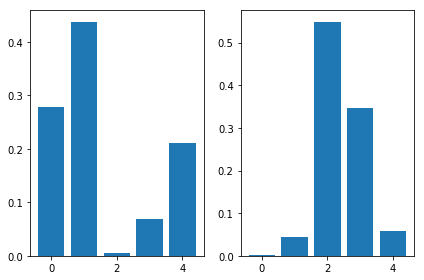

Bag of words mapping function:
{'like': 3, 'dog': 2, 'cat': 1, 'amy': 0, 'love': 4}
******Collapsed Gibbs Sampling******
Document topic proportion:
[[ 1.   0. ]
 [ 0.8  0.2]
 [ 0.   1. ]
 [ 0.   1. ]
 [ 1.   0. ]]
Topic word proportion
[[ 0.          0.          0.66666667  0.33333333  0.        ]
 [ 0.25        0.41666667  0.08333333  0.          0.25      ]]
Visualization


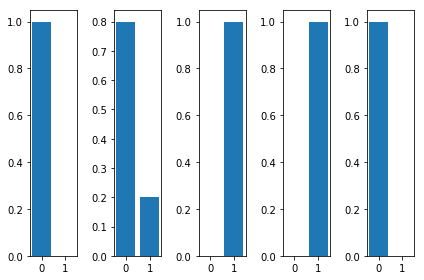

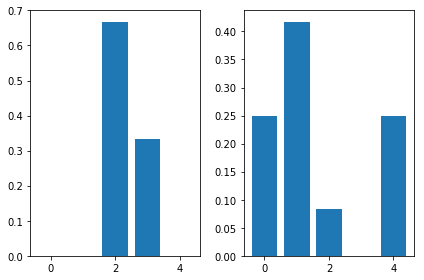

Bag of words mapping function:
{'like': 3, 'dog': 2, 'cat': 1, 'amy': 0, 'love': 4}


In [92]:
mylda = myLDA(N_K=2)
test_doc = ['I like dog',
           'dog dog dog I like dog',
           'cat cat cat Amy love cat',
           'Amy love cat Amy love',
           'dog dog like I']
tf_vectorizer_test = CountVectorizer()
tf_test = tf_vectorizer_test.fit_transform(test_doc)
(Theta_sgs, Beta_sgs) = mylda.lda_sgs(tf_test)
print("******Standard Gibbs Sampling******")
print("Document topic proportion:")
print(Theta_sgs)
print("Topic word proportion")
print(Beta_sgs)
print("Visualization")
mylda.visualization(Theta_sgs,Beta_sgs)
print("Bag of words mapping function:")
print(tf_vectorizer_test.vocabulary_)

(Theta_cgs, Beta_cgs) = mylda.lda_cgs(tf_test)
print("******Collapsed Gibbs Sampling******")
print("Document topic proportion:")
print(Theta_cgs)
print("Topic word proportion")
print(Beta_cgs)
print("Visualization")
mylda.visualization(Theta_cgs,Beta_cgs)
print("Bag of words mapping function:")
print(tf_vectorizer_test.vocabulary_)

- Comparison example

Visualization for myLDA via collapsed Gibbs sampling


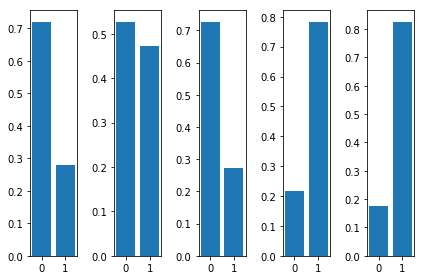

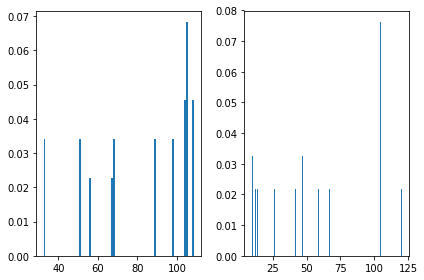

Visualization for sklearn LDA


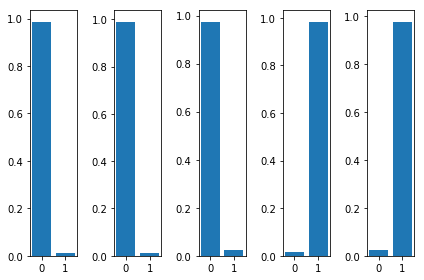

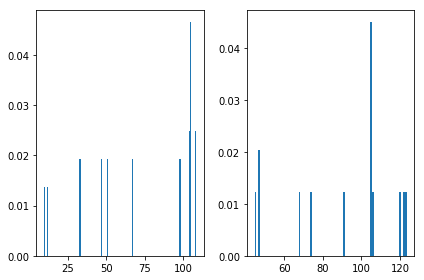

In [93]:
mylda2 = myLDA(N_K=2)

test_doc = ['Dropbox, the online file storage company, said on Monday that it hoped to raise as much as $648 million in its forthcoming stock market debut, setting up the final stage along its path to becoming the next big publicly traded Silicon Valley darling.',
           'In an updated prospectus, Dropbox said that it planned to sell 36 million shares between $16 and $18 a share. At the midpoint of that range, the company would be valued at roughly $7.5 billion, factoring in restricted stock units and options. That is down from its most recent valuation of $10 billion from previous private investors.',
           'Dropbox is likely to begin trading on the Nasdaq stock market — under the ticker symbol “DBX” — by the end of next week.',
           'United had hoped the sweepstakes approach would “build excitement and a sense of accomplishment.” But after workers deluged the company with hostile comments, the airline said last week that it was “pressing the pause button on these changes.”',
           '“Lotteries in general may be more effective than fixed payments, as people tend to overweigh small probabilities in making decisions,” the paper noted.']

tf_vectorizer2 = CountVectorizer()
tf2 = tf_vectorizer2.fit_transform(test_doc)
Theta, Beta = mylda2.lda_cgs(tf2,max_iter=100)
print("Visualization for myLDA via collapsed Gibbs sampling")
mylda2.visualization(Theta,Beta,m=10)

tf_vectorizer_sl = CountVectorizer()
tf_sl = tf_vectorizer_sl.fit_transform(test_doc)
lda_sl = LatentDirichletAllocation(n_components=2, learning_method='batch')
lda_sl.fit(tf_sl)
Theta_sl = lda_sl.transform(tf_sl) / lda_sl.transform(tf_sl).sum(axis=1)[:, np.newaxis]
Beta_sl = lda_sl.components_ / lda_sl.components_.sum(axis=1)[:, np.newaxis]
print("Visualization for sklearn LDA")
mylda2.visualization(Theta_sl,Beta_sl,m=10)

## references

1. David M.Blei, Andrew Y.Ng, Micheal I.Jordan. Latent Dirichlet allocation. http://www.jmlr.org/papers/volume3/blei03a/blei03a.pdf
2. Lecture of topic model delivered by David M.Blei. http://videolectures.net/mlss09uk_blei_tm/.
3. Chandler May, Alex Clemmer and Benjamin Van Durme. Particle Filter Rejuvenation and Latent Dirichlet Allocation. http://www.aclweb.org/anthology/P14-2073.
4. William M. Darling. A Theoretical and Practical Implementation Tutorial on Topic Modeling and Gibbs Sampling. http://u.cs.biu.ac.il/~89-680/darling-lda.pdf.